In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.saving.saved_model.serialized_attributes import metrics


In [2]:

# Set the number of rows of data
num_rows = 1000

In [3]:
# Save the data to a CSV file
data = pd.read_csv("./vehicle_telemetry_data.csv")


In [4]:

# Show the first few rows of the data
data.head()

,VehicleID,Speed,EngineTemperature,FuelLevel,Timestamp
0,V003,114.220784,115.085061,79.271063,2025-01-01 00:00:00
1,V005,45.219229,85.285633,67.328779,2025-01-01 01:00:00
2,V002,61.261954,86.139084,19.014222,2025-01-01 02:00:00
3,V002,68.976687,92.230290,73.636116,2025-01-01 03:00:00
4,V001,91.969425,72.643201,22.133129,2025-01-01 04:00:00


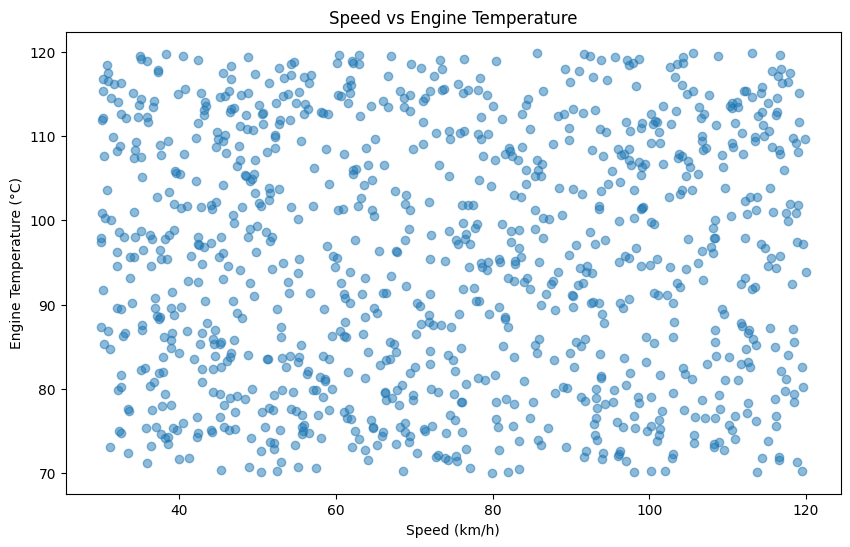

In [5]:
# Plot Speed vs Engine Temperature for visualization
plt.figure(figsize=(10, 6))
plt.scatter(data['Speed'], data['EngineTemperature'], alpha=0.5)
plt.title('Speed vs Engine Temperature')
plt.xlabel('Speed (km/h)')
plt.ylabel('Engine Temperature (°C)')
plt.show()

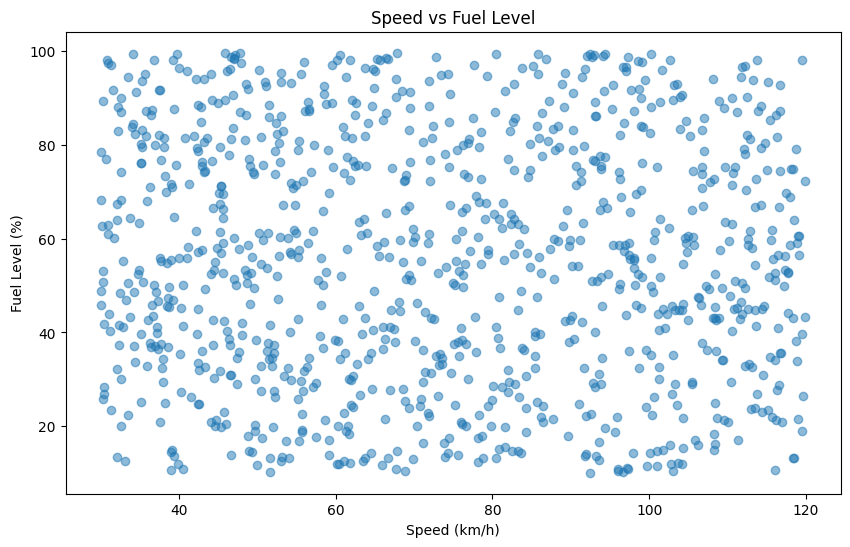

In [6]:
# Plot Speed vs Fuel Level for visualization
plt.figure(figsize=(10, 6))
plt.scatter(data['Speed'], data['FuelLevel'], alpha=0.5)
plt.title('Speed vs Fuel Level')
plt.xlabel('Speed (km/h)')
plt.ylabel('Fuel Level (%)')
plt.show()

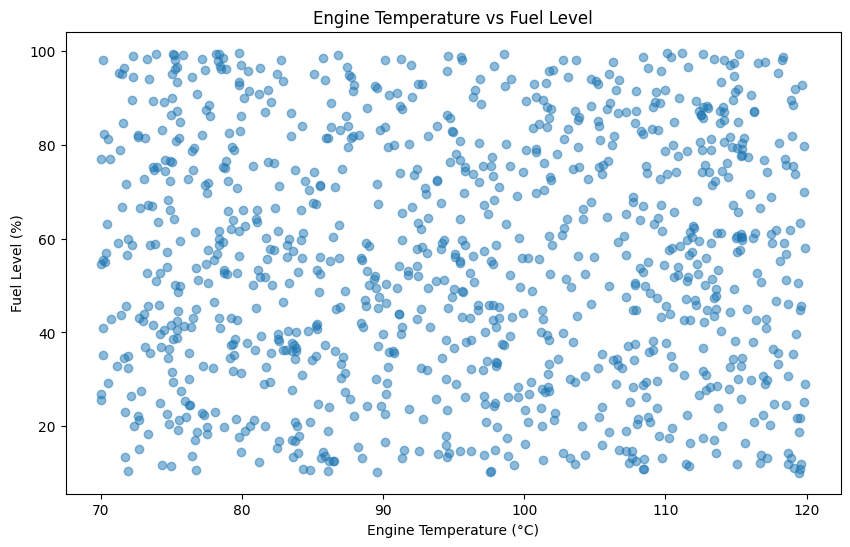

In [7]:
# Plot Engine Temperature vs Fuel Level for visualization
plt.figure(figsize=(10, 6))
plt.scatter(data['EngineTemperature'], data['FuelLevel'], alpha=0.5)
plt.title('Engine Temperature vs Fuel Level')
plt.xlabel('Engine Temperature (°C)')
plt.ylabel('Fuel Level (%)')
plt.show()


time to make a prediction model and make it predict the engine health

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Convert Timestamp to datetime and sort data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.sort_values(by=["VehicleID", "Timestamp"])

# Select relevant features
features = ["Speed", "EngineTemperature", "FuelLevel"]

# Normalize features (LSTMs work better with scaled data)
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Define sequence length (e.g., use last 5 readings to predict the next)
sequence_length = 5

X_seq, y_seq = [], []

# Group by vehicle to create sequences for each vehicle separately
for _, vehicle_data in data.groupby("VehicleID"):
    vehicle_values = vehicle_data[features].values
    for i in range(len(vehicle_values) - sequence_length):
        X_seq.append(vehicle_values[i:i + sequence_length])  # Past readings
        y_seq.append(vehicle_values[i + sequence_length])  # Predict next reading

# Convert to numpy arrays
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Save for training
np.save("X_seq.npy", X_seq)
np.save("y_seq.npy", y_seq)

print(f"Data Preprocessed! X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")


Data Preprocessed! X_seq shape: (975, 5, 3), y_seq shape: (975, 3)


In [9]:
from keras import Input
# Load the telemetry data to tensor and normalize the data
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split

# Assuming X_seq is your time series data shaped as (samples, timesteps, features)
# and y_seq is your corresponding labels.
# For example, you might have a sliding window of sensor readings.
X_seq = np.load("X_seq.npy")
y_seq = np.load("y_seq.npy")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Use Input layer
    LSTM(50, activation='relu'),
    Dense(3)  # Predicting Speed, EngineTemperature, and FuelLevel
])
# Train the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2577 - mae: 0.4224 - val_loss: 0.1052 - val_mae: 0.2759
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0974 - mae: 0.2664 - val_loss: 0.0890 - val_mae: 0.2576
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0893 - mae: 0.2568 - val_loss: 0.0885 - val_mae: 0.2567
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0892 - mae: 0.2587 - val_loss: 0.0882 - val_mae: 0.2562
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0898 - mae: 0.2593 - val_loss: 0.0879 - val_mae: 0.2560
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0875 - mae: 0.2560 - val_loss: 0.0875 - val_mae: 0.2554
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0886 - mae: 0.2575 - val_loss: 0.0872 - val_mae: 0.2550
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0877 - mae: 0.2558 - val_loss: 0.0870 - val_mae: 0.2551
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0858 - mae: 

In [10]:
# optimize the model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(BatchNormalization())
model2.add(Dense(3, activation='sigmoid'))  # For binary classification

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/50


E:\OSlab\.venv\bikehike1\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3244 - loss: 0.7080 - val_accuracy: 0.3385 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3606 - loss: 0.6950 - val_accuracy: 0.3333 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3793 - loss: 0.6921 - val_accuracy: 0.3333 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3716 - loss: 0.6912 - val_accuracy: 0.3436 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3834 - loss: 0.6910 - val_accuracy: 0.3641 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3843 - loss: 0.6907 - val_accuracy: 0.3641 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3775 - loss: 0.6897 - val_accuracy: 0.3641 - v

In [11]:
model2.save("bike_health_model.keras")